# <center>  Enhancer Pixel Sequence  Deep Convolutional Generative Adversarial Network </center>

# Importing Libararies

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, LeakyReLU, Conv1D, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import time

In [2]:
import tensorflow as tf 

if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5313985408120795599
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6308302402007165908
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23452604826
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4623916171888509529
physical_device_desc: "device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 513540096
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamEx

# Preprocessing the files taken from Slide base

In [ ]:
with open("enhancers2.txt", "r") as f:
    lines = f.readlines()
with open("enhancers2p.txt", "w") as f:
    for line in lines:
        if line.startswith(">")!=True:
            f.write(line[0:152])
            f.write('\n')

In [ ]:

name=""
with open("enhancers1.txt", "r") as f:
    lines = f.readlines()
for i in range(len(lines)//104):
    name=str(i)+".txt"
    with open(name, "w") as f:
        if (count<105):
            for line in lines:
                if line.startswith(">")!=True and count<104:
                    line.upper()
                    f.write(line[0:152])
                    f.write('\n')
                    lines.remove(line)
                    count+=1
    count=0        
   

In [ ]:
len(lines)

# Defining a function for reading and conversion of data 

In [3]:
def preprocess_data(path, i):
    #reading motifs from a FASTA file
    df = pd.read_csv(path, header=None)
    #Converitng a dataframe into a numpy array
    arr1= np.array(df.iloc[:,:])
    newarr=[]
    for i in range (len(arr1)):
        temp=np.array_str(arr1[i])
        temp2=filter(str.isalnum, temp)
        arr2=np.array(list(temp2))
        newarr.append(arr2)
    motif=np.array(newarr)
    #print("Sequences converted to numpy array...")
    num_rows = np.shape(motif)[0]
    num_cols = np.shape(motif)[1]
    motif2 = np.zeros_like(motif, dtype='uint8')
    for i in range (num_rows):
        for j in range (num_cols):
            if(motif[i,j]=='A' or motif[i,j]=='a'):
                motif2[i,j]=0
            if motif[i,j]=='T' or motif[i,j]=='t':
                motif2[i,j]=150
            if motif[i,j]=='C' or motif[i,j]=='c':
                motif2[i,j]=85 
            if motif[i,j]=='G' or motif[i,j]=='g':
                motif2[i,j]=255      
    #print("Numpy array converted to 8 bit int...")
    img = Image.fromarray(motif2)
    img.save(str(i)+'.png')
    #print("Image size",img.size)
    #print("Image...")
    #plt.figure(1, figsize=(10, 10))
    #plt.imshow(img, cmap="gray")
    #plt.savefig('gpx')
    return img


In [3]:
imgs=[]
for i in tqdm(range(len(lines)//104)):
    #print(i)
    j=i+312
    imgs.append(preprocess_data((str(i) + '.txt'), j)) 
    imgs[i].save("images/"+(str(j)+'.png'))

    
    

#image = preprocess_data('motifs.txt')

NameError: name 'lines' is not defined

In [10]:
len(imgs)

0

In [11]:
plt.imshow(imgs[312], cmap='gray')

IndexError: list index out of range

In [3]:
# Checking whether the image has been saved in correct dimensions or not
pic = Image.open("C:/Users/Administrator/Desktop/gans/gpxi/motifs.png")
width, height = pic.size
print("cols =",width," rows =", height)

cols = 152  rows = 104


# Defining the variables for the ease of use in the code

In [4]:

pic_dir = './images/'
images_count = 600
width = 152
height = 104
images = []
x1 =  0
y1 = 0
x2 = 152
y2 = 104
crop_rectangle= (x1,y1, 152, 104)

In [5]:
len(os.listdir(pic_dir))

626

In [6]:
for pic_file in tqdm(os.listdir(pic_dir)[:images_count]):
    # Saving the aspect ratio and properties of images using thumbnail and antialias
    pic = Image.open(pic_dir + pic_file)
    pic=pic.crop(crop_rectangle)
    images.append(img_to_array(pic))

100%|██████████| 600/600 [00:00<00:00, 1270.26it/s]


# Converting the images into num

In [7]:
# Converting images into numpy and normalizing the vals
images = ((np.array(images)-127.5)/ 127.5)
print("Images Normalized...")

Images Normalized...


In [8]:
# Confirming the size
images[0].shape

(104, 152, 1)

In [9]:
def create_batch(x_train): 
    batch_size = 30
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000) 
    # Combines consecutive elements of this dataset into batches. 
    dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1) 
    # Creates a Dataset that prefetches elements from this dataset 
    return dataset

In [10]:
dataset = create_batch(images)

# Defining the Generator side of the DCGAN

In [11]:
latent_vector = 100
channel = 1
def generator_model():
    # Flattened and noise vector
    generator_input = keras.Input(shape = (latent_vector,))
    
    # Starting from a Dense layer
    x = Dense(100 * 13 * 19)(generator_input)
    x = LeakyReLU()(x)
    
    # Reshaping to organize 
    x = Reshape((13, 19, 100))(x)
    
    # Applying convlution operation to get some initial features
    # Applying 155 filters with a kernel size of 5
    # We dont add padding to make it of equivalent size as input
    x = Conv2D(filters = 256, kernel_size = 5, strides=1, padding="same")(x)
    x = LeakyReLU()(x)
    
    # Applying the transpose operation so that when the conv is applied we get matrix of higher dimensions i-e. https://www.machinecurve.com/index.php/2019/09/29/understanding-transposed-convolutions/
    # https://distill.pub/2016/deconv-checkerboard/
    x = Conv2DTranspose(filters = 256, kernel_size = 4, strides=2, padding = "same")(x)
    x = LeakyReLU()(x)
    
    # Conv2DTrans num 2
    x = Conv2DTranspose(filters = 256, kernel_size = 4, strides=2, padding = "same")(x)
    x = LeakyReLU()(x)

    # Conv2DTrans num 3
    x = Conv2DTranspose(filters = 256, kernel_size = 4, strides=2, padding = "same")(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(filters = 512, kernel_size = 4, padding="same" )(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(filters = 512, kernel_size = 6, padding="same" )(x)
    x = LeakyReLU()(x)
    
    
    x = Conv2D(channel, kernel_size = 7, activation='tanh', padding='same')(x)

    generator = Model(generator_input, x)
    
    return generator

In [12]:
generator=generator_model()
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 24700)             2494700   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 24700)             0         
_________________________________________________________________
reshape (Reshape)            (None, 13, 19, 100)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 19, 256)       640256    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 13, 19, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 26, 38, 256)       104883

# Defining the Discriminator side of the DCGAN

In [13]:
def create_discriminator():
    
    # Defining the shape of the input that is to be given as input
    discriminator_input = keras.Input(shape = (104, 152, 1))
    
    # Defining the convolution layer in a way so that the size is reduced to its half
    x = Conv2D(filters = 228, kernel_size = 2, strides = 2)(discriminator_input)
    x = LeakyReLU()(x)
    
    # conv layer 2
    x = Conv2D(filters=104, kernel_size=2, strides=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(rate=0.3)(x)
    
    # conv layer 3
    x = Conv2D(filters=52, kernel_size=2, strides=2)(x)
    x = LeakyReLU()(x)
    
    # conv layer 4
    # x = Conv2D(filters=26, kernel_size=2, strides=2)(x)
    #x = LeakyReLU()(x)
    
    # Flattening the matrixes
    x = Flatten()(x)
    
    # Performing the regularization to minimize overfitting
    x = Dropout(rate=0.3)(x)
    
    # Defining the output from the discriminator which is always the probability
    x = Dense(units=1, activation='sigmoid')(x)
    
    # From a tensor to a complete model
    discriminator = Model(discriminator_input , x )
    '''
    # Defining the optimizer for the Discriminator
    optimizer = tf.keras.optimizers.RMSprop(
        rho=0.9,
        momentum=0.0,
        epsilon=1e-07,
        centered=False,
        learning_rate=0.001,
        clipvalue=1.0
    )
    
    # Compiling the model
    discriminator.compile(
        optimizer = optimizer,
        loss = keras.losses.binary_crossentropy
    )
    '''
    return discriminator

In [14]:
discriminator=create_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 104, 152, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 52, 76, 228)       1140      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 52, 76, 228)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 38, 104)       94952     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 26, 38, 104)       0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 38, 104)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 19, 52)        2168

# Creating the image using the untrained Generator

**Using the (as yet untrained) generator to create an image.**

tensor created with the random values of size 100 ...


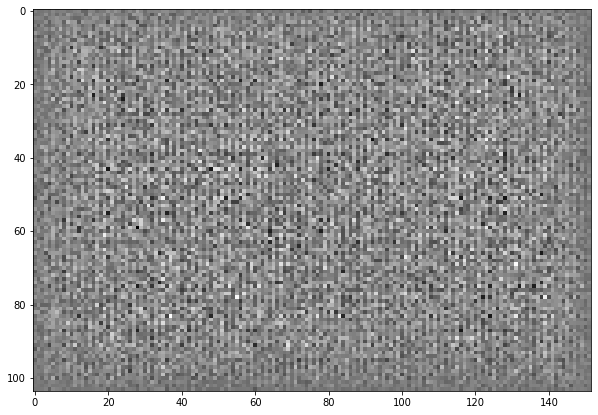

In [15]:
# Creating random vector of size 100 from Normal Distribution
noise = tf.random.normal([1,100])
print("tensor created with the random values of size 100 ...")

# No training has been specified
generated_image = generator(noise, training=False)
plt.figure(1, figsize=(10, 10))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Using untrained discriminator to classify the generated images as real or fake

**The model will be trained to output positive values for real images, and negative values for fake images.**

In [16]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5000307]], shape=(1, 1), dtype=float32)


# Compiling and combining phase

In [17]:
# compile discriminator using binary cross entropy loss and adam optimizer 
discriminator.compile(loss ="binary_crossentropy", optimizer ="adam") 
# make  discriminator no-trainable as of  now 
discriminator.trainable = False

In [18]:
# Combine both generator and discriminator 
gan = keras.models.Sequential([generator, discriminator])
# compile generator using binary cross entropy loss and adam optimizer
gan.compile(loss="binary_crossentropy", optimizer="adam")

# Defining the Training 

In [19]:
epochs = 500
# We have already defined latent_vector ppreviously
batch_size = 30
# Creating the random vector from noise 
total_vec_seed = tf.random.normal(shape=[batch_size, latent_vector])


In [20]:
total_vec_seed

<tf.Tensor: id=1001, shape=(30, 100), dtype=float32, numpy=
array([[ 1.0365505 , -2.2619479 , -0.5402259 , ..., -1.5137606 ,
        -0.87049186, -0.5714703 ],
       [-0.73078895,  1.1813049 ,  0.1469629 , ..., -1.5135177 ,
         1.4807377 ,  2.388396  ],
       [ 0.51137495, -1.4822015 , -1.2313921 , ...,  0.09973925,
        -1.4344879 ,  0.15516837],
       ...,
       [ 2.3045754 ,  0.7163448 ,  0.27195305, ...,  0.34491765,
        -0.43863866, -1.189957  ],
       [-1.2300974 , -0.00638236,  1.7627546 , ...,  0.6059328 ,
        -0.34926203,  0.3411445 ],
       [ 1.423644  , -1.083391  ,  0.19278722, ...,  0.43166655,
         0.5528191 ,  0.8979456 ]], dtype=float32)>

In [29]:
def train_dcgan(gan, images, batch_size, num_features, epochs=3):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print()
        print("Epoch {}/{}".format(epoch + 1, epochs))
        for X_batch in images:
            # Create a random noise of size batch * 100
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
           
            # Combining the real and fake images to train the discriminator
            fake_and_real = tf.concat((generated_images, X_batch), axis=0)
            
            # Providing batch of real and fake images to the discrimnator
            # training the discriminator using it
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable=True
            discriminator.train_on_batch(fake_and_real, y1)
            # Training the GAN
            # Providing the generated images and fooling the discriminator with fake labels of 1
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise, y2)
        
            # Generate and save images
            generate_and_save_images(generator, epoch+1, noise)
            
        print(discriminator.evaluate(fake_and_real, y1))
        
        
        generate_and_save_images(generator, epochs, noise)

# Defining and saving Image Generation Via Generator

In [30]:
preds_to =list()
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    preds_to.append(predictions)
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        preds_to_show = predictions[i, :, :] * 127.5 + 127.5
        preds_to_show = np.squeeze(preds_to_show)
        plt.imshow(preds_to_show, cmap='gray')
        plt.axis('off')
        
    
    plt.savefig('image_epoch_{:04d}.png'.format(epoch))

In [33]:
preds_to

[<tf.Tensor: id=264730, shape=(30, 104, 152, 1), dtype=float32, numpy=
 array([[[[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         ...,
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]]],
 
 
        [[[-1.],
          [-1.],
          [-1.],
          ...,
          [-1.],
          [-1.],
          [-1.]],
 
         [[-1.],
          [-1.],
          [-1.],
          ...,
    

In [ ]:

train_dcgan(gan, dataset, batch_size, latent_vector, epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]


Epoch 1/5000
60/1 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

/home/ahtisham/anaconda3/envs/final_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
  0%|          | 1/5000 [00:45<62:37:58, 45.10s/it]


Epoch 2/5000
